In [1]:
import numpy as np
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import seaborn as sns

from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator


### Project Description:

This project is about differentiating a weed from a crop seedling. The ability to do effectively can mean better crop yields and better stewardship of the environment. The Aarhus University Signal Processing group, in collaboration with University of Southern Denmark, has recently released a dataset containing images of unique plants belonging to 12 species at several growth stages


We are provided with a dataset of images of plant seedlings at various stages of grown.Each image has a filename that is its unique id. The dataset comprises 12 plant species. The goal of the projectis to create a classifier capable of determining a plant's species from a photo.

### Dataset:
The images were converted to images.npy file and the labels are also  put  into  the  Labels.csv.


In [2]:
### Load the data

In [3]:
data = np.load('images.npy')
y = pd.read_csv('Labels.csv')

### Shape of the data

In [4]:
data.shape

(4750, 128, 128, 3)

In [5]:
y.value_counts(normalize=True).round(2)

Label                    
Loose Silky-bent             0.14
Common Chickweed             0.13
Scentless Mayweed            0.11
Small-flowered Cranesbill    0.10
Fat Hen                      0.10
Charlock                     0.08
Sugar beet                   0.08
Cleavers                     0.06
Black-grass                  0.06
Shepherds Purse              0.05
Maize                        0.05
Common wheat                 0.05
dtype: float64

### Visualizing the label distribution

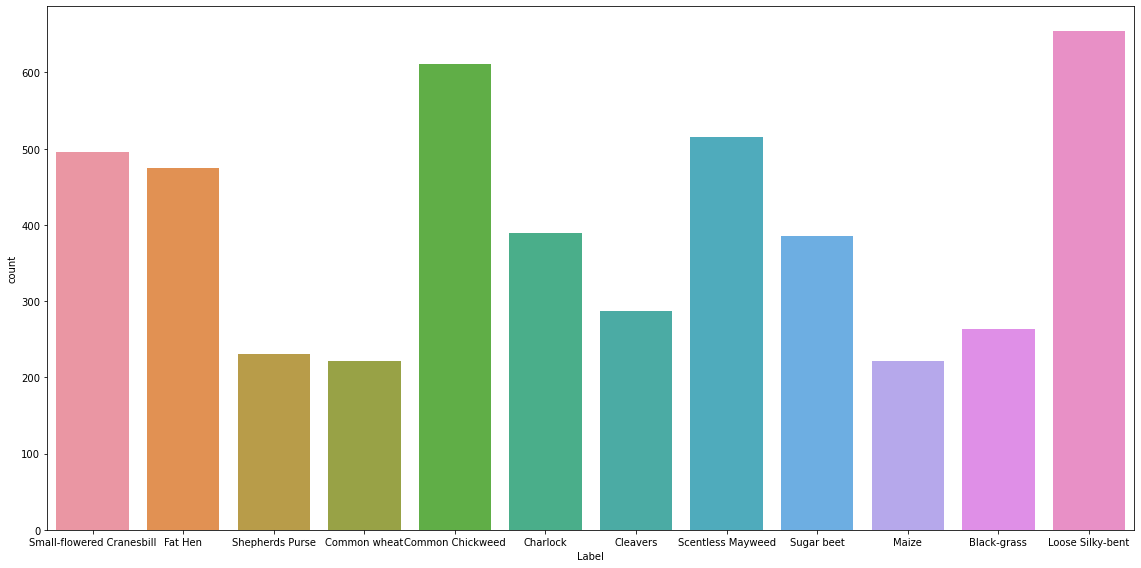

In [6]:
plt.figure(figsize=(16,8))
sns.countplot(x=y['Label'])
plt.tight_layout()

## Visualizing the images

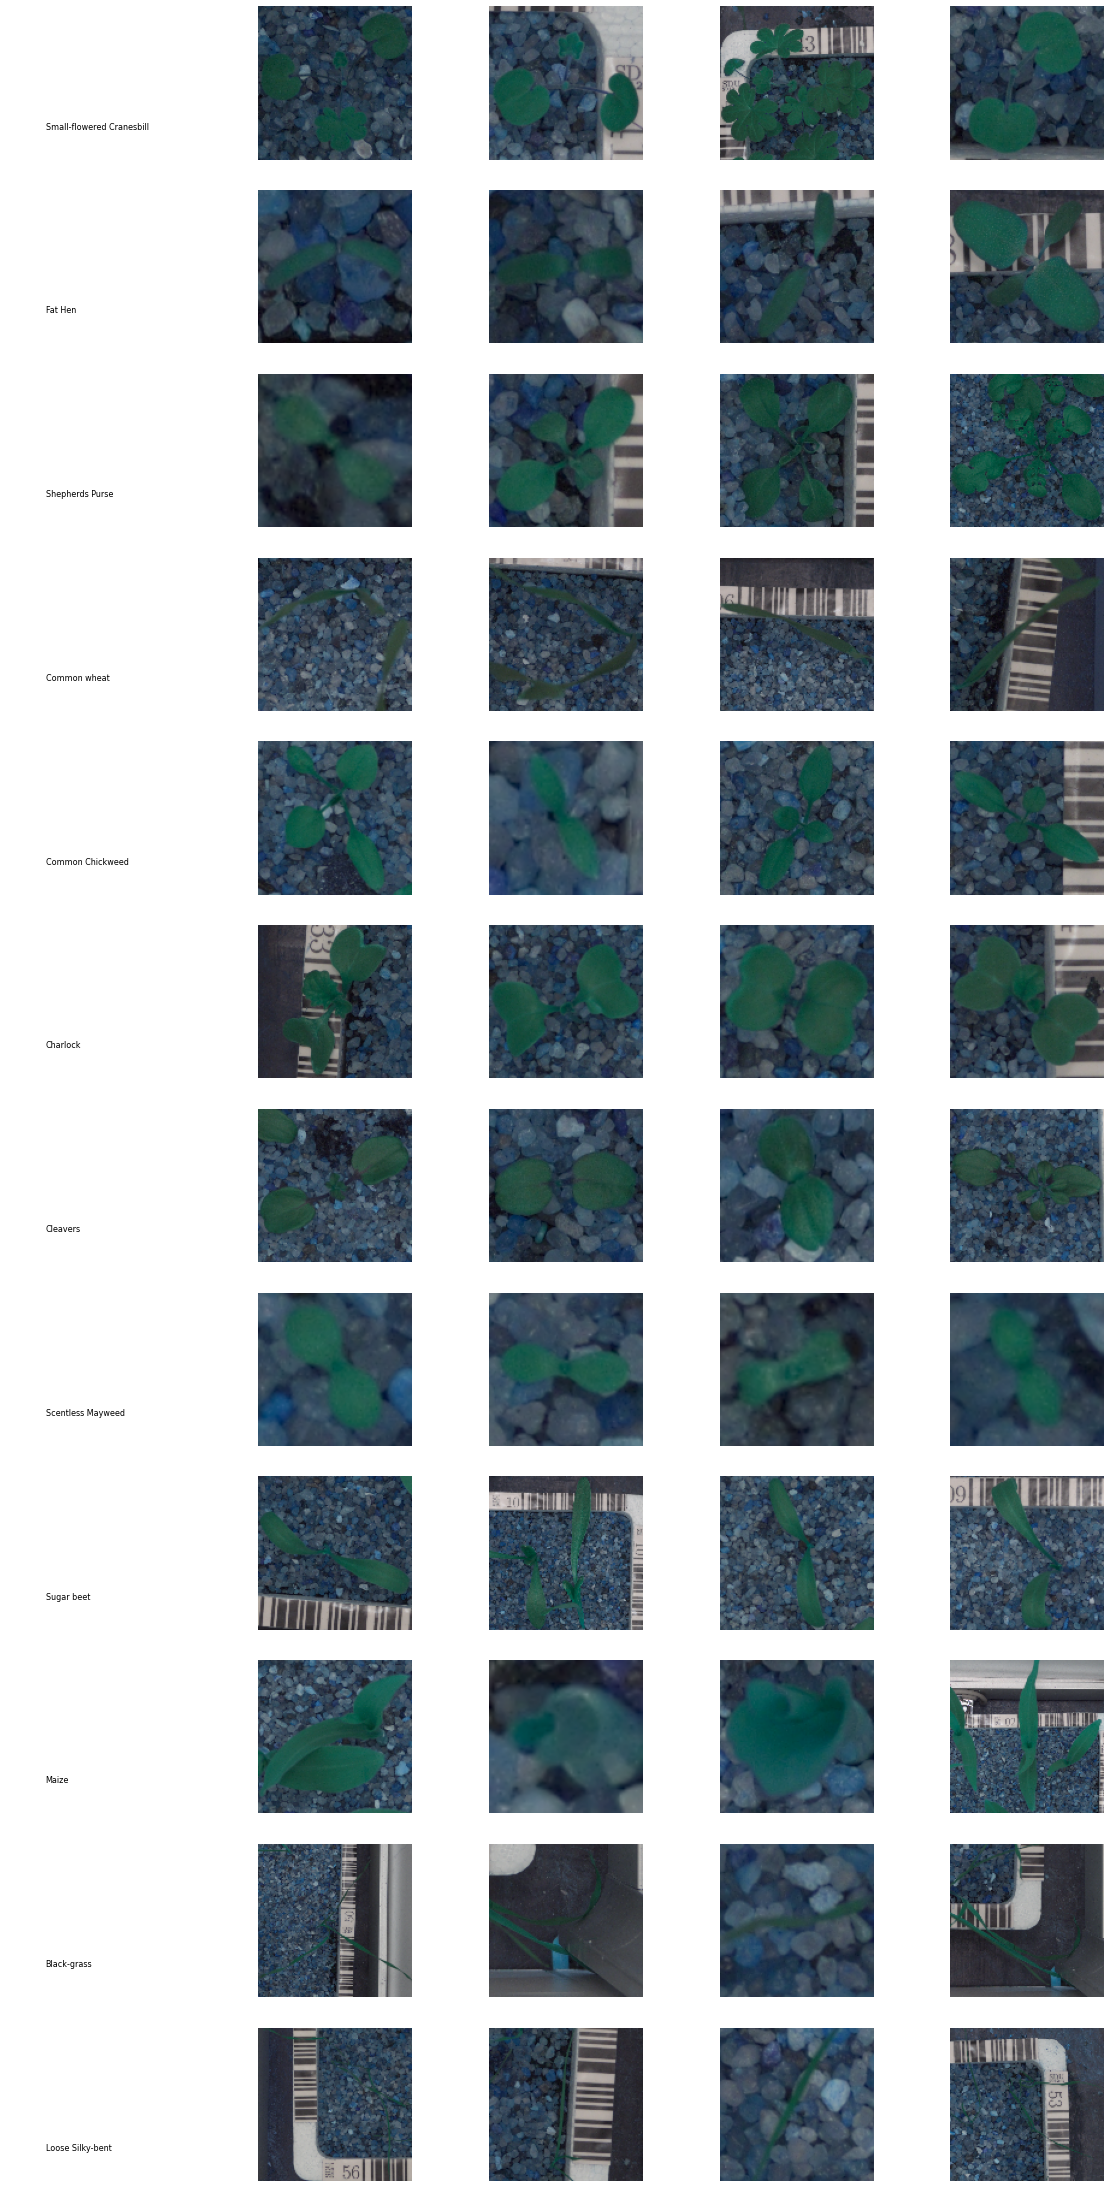

In [7]:

distinct_labels = list(y['Label'].unique())
fig = plt.figure(figsize=(20,40))
i=0
rows = 12 # since 12 different plant seedlings available
columns = 5 # 
for label in distinct_labels:
    index_positions = y.loc[y["Label"]==label].index[:5]
    j = 0
    for index in index_positions:
        j=j+1
        ind_loc = i*5+j
        if ind_loc <=60:
            fig.add_subplot(rows,columns,ind_loc)
        plt.axis('off')
        if(j==1):
            plt.text(0.2,0.2,label,fontsize=8,wrap=True)
            continue
        plt.imshow(data[index])   
        if j==5:
            i+=1
            break
        

### Preprocessing the Data
 - Normalize the data
 - Apply the Gaussian blur

In [8]:


data = data.astype('float32')/255.0

data_guassian_blur = data.copy()
for idx, line in enumerate(data):
    data_guassian_blur[idx] = cv2.GaussianBlur(data_guassian_blur[idx],(5,5),0)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(data_guassian_blur, y, test_size=0.2, random_state=42)

### Visualizing the image before and after Gaussian blur

In [10]:
y.loc[1]

Label    Small-flowered Cranesbill
Name: 1, dtype: object

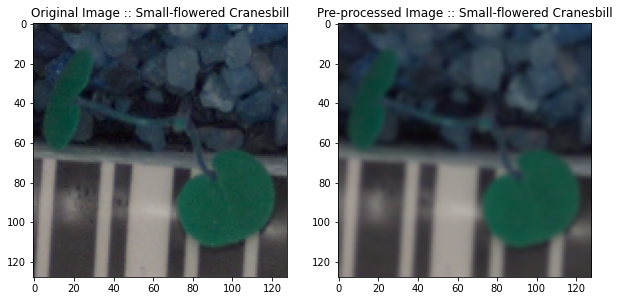

In [11]:
i=10
fig = plt.figure(figsize=(10,20))
ax1 = fig.add_subplot(2,2,1)
img = data[i]
plt.title("Original Image :: "+y.loc[i][0])
ax1.imshow(img)
ax2 = fig.add_subplot(2,2,2)
img2 = data_guassian_blur[i]
plt.title("Pre-processed Image :: "+y.iloc[i][0])
ax2.imshow(img2)

In [12]:
# Convert labels to one hot vectors. It can be done using keras to_categorical util as well

from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
# y= keras.utils.to_categorical(y)
y_train = enc.fit_transform(y_train)
y_test = enc.fit_transform(y_test)

In [13]:
y_train.shape

(3800, 12)

In [14]:
# Print the shape of dataset.
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (3800, 128, 128, 3)
3800 train samples
950 test samples


In [15]:
### using an Architecture similar to LeNet

### Conv2D:
Keras Conv2D is a 2D Convolution Layer, this layer creates a convolution kernel that is wind with layers input which helps produce a tensor of outputs.
### Activation('relu'):
'relu' stands for Rectified linear unit. It is the most widely used activation function. Chiefly implemented in hidden layers of Neural network.
ReLu is less computationally expensive than tanh and sigmoid because it involves simpler mathematical operations. At a time only a few neurons are activated making the network sparse making it efficient and easy for computation.
### MaxPooling2D:
The objective MaxPooling Layer is to down-sample an input representation.
This is done to in part to help over-fitting by providing an abstracted form of the representation. As well, it reduces the computational cost by reducing the number of parameters to learn.
### Dropout:
Dropout is a technique used to improve over-fit on neural networks.
Basically during training half of neurons on a particular layer will be deactivated. This improve generalization.
Normally some deep learning models use Dropout on the fully connected layers, but is also possible to use dropout after the max-pooling layers, creating some kind of image noise augmentation.
### Dense:
Dense layer implements the operation: output = activation(dot(input, kernel) + bias) where activation is the element-wise activation function passed as the activation argument, kernel is a weights matrix created by the layer, and bias is a bias vector created by the layer (only applicable if use_bias is True).
### Softmax:
The softmax function is also a type of sigmoid function but is handy when we are trying to handle classification problems.
Usually used when trying to handle multiple classes. The softmax function would squeeze the outputs for each class between 0 and 1 and would also divide by the sum of the outputs.

In [16]:
# Set the batch size, number of epochs.
batch_size = 32
num_classes = 12 ## There are total 12 classes
epochs = 50
# num_predictions = 20

In [17]:
def create_model():
#     batch_size = None 
    model = models.Sequential()
    model.add(layers.Conv2D(32, (5, 5), padding='same', activation="relu", input_shape=X_train.shape[1:]))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Conv2D(64, (5, 5), padding='same', activation="relu"))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.3))
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation="relu"))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.4))
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation="relu"))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.5))

    model.add(layers.GlobalMaxPooling2D())
    model.add(layers.Dense(256, activation="relu"))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(12, activation="softmax"))
    return model


In [18]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      2432      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        51264     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0

In [19]:
# initiate Adam optimizer
opt = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
# # Let's train the model using RMSprop

model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      2432      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        51264     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0

### Defining the early_stopping crieteria with min_delta of 0.001 for continous 10 epochs

In [20]:
#Adding Early stopping callback to the fit function is going to stop the training,
#if the val_loss is not going to change even '0.001' for more than 10 continous epochs


early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10)

#Adding Model Checkpoint callback to the fit function is going to save the weights whenever val_loss achieves a new low value. 
#Hence saving the best weights occurred during training

model_checkpoint =  ModelCheckpoint('Model_Checkpoint_{epoch:02d}_loss{val_loss:.4f}.h5',
                                                           monitor='val_loss',
                                                           verbose=1,
                                                           save_best_only=True,
                                                           save_weights_only=True,
                                                           mode='auto',
                                                           period=1)

Epoch 1/75
119/119 [==============================] - 21s 87ms/step - loss: 4.9159 - accuracy: 0.1511 - val_loss: 2.5163 - val_accuracy: 0.0800
Epoch 2/75
119/119 [==============================] - 9s 73ms/step - loss: 1.8999 - accuracy: 0.3492 - val_loss: 2.5672 - val_accuracy: 0.0979
Epoch 3/75
119/119 [==============================] - 9s 74ms/step - loss: 1.5963 - accuracy: 0.4360 - val_loss: 2.4482 - val_accuracy: 0.2053
Epoch 4/75
119/119 [==============================] - 9s 75ms/step - loss: 1.4484 - accuracy: 0.4976 - val_loss: 2.1622 - val_accuracy: 0.2421
Epoch 5/75
119/119 [==============================] - 9s 76ms/step - loss: 1.3663 - accuracy: 0.5362 - val_loss: 2.1115 - val_accuracy: 0.3021
Epoch 6/75
119/119 [==============================] - 9s 77ms/step - loss: 1.2604 - accuracy: 0.5719 - val_loss: 1.7594 - val_accuracy: 0.3926
Epoch 7/75
119/119 [==============================] - 9s 77ms/step - loss: 1.1929 - accuracy: 0.6005 - val_loss: 1.7762 - val_accuracy: 0.377

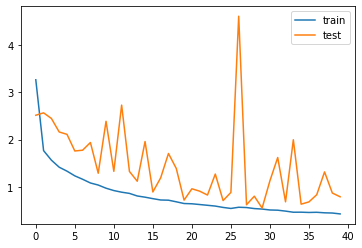

In [21]:
import tensorflow as tf
epochs = 75

log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

with tf.device('/gpu:0'): ### Running it on GPU
    history = model.fit(X_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(X_test, y_test),
                    shuffle=True,
                    verbose=1,
                    callbacks=[early_stopping])

# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [22]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [23]:
# Score trained model.
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

30/30 [==============================] - 1s 47ms/step - loss: 0.7894 - accuracy: 0.7432
Test loss: 0.7894234657287598
Test accuracy: 0.7431579232215881


<AxesSubplot:>

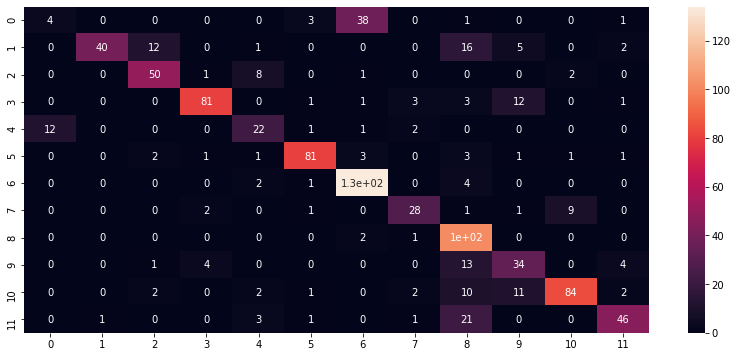

In [24]:
y_pred = model.predict(X_test)
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
plt.figure(figsize=(14,6))
sns.heatmap(cm,annot=True)

In [25]:
print(f'Label {distinct_labels[0]} and {distinct_labels[1]} has more false predictions')

Label Small-flowered Cranesbill and Fat Hen has more false predictions


### Exploring Data Augmentation

In [26]:
# X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2, random_state=42) ## using the original data rather than guassian blur data

In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
                    horizontal_flip=True,
                    vertical_flip= True,
                    fill_mode='nearest')
train_datagen.fit(X_train)

In [28]:
model_augmented = create_model()
model_augmented.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 128, 128, 32)      2432      
_________________________________________________________________
batch_normalization_4 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 64, 64)        51264     
_________________________________________________________________
batch_normalization_5 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 32, 64)       

In [29]:
# initiate Adam optimizer
opt = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
# # Let's train the model using RMSprop

model_augmented.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])


Epoch 1/75


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


118/118 [==============================] - 10s 78ms/step - loss: 4.9080 - accuracy: 0.1725 - val_loss: 2.5624 - val_accuracy: 0.0495
Epoch 2/75
118/118 [==============================] - 9s 76ms/step - loss: 1.8112 - accuracy: 0.3619 - val_loss: 2.9162 - val_accuracy: 0.1484
Epoch 3/75
118/118 [==============================] - 9s 76ms/step - loss: 1.5536 - accuracy: 0.4582 - val_loss: 3.5371 - val_accuracy: 0.1484
Epoch 4/75
118/118 [==============================] - 9s 76ms/step - loss: 1.4390 - accuracy: 0.5067 - val_loss: 2.0951 - val_accuracy: 0.2937
Epoch 5/75
118/118 [==============================] - 9s 76ms/step - loss: 1.2628 - accuracy: 0.5620 - val_loss: 2.5446 - val_accuracy: 0.2368
Epoch 6/75
118/118 [==============================] - 9s 76ms/step - loss: 1.2584 - accuracy: 0.5816 - val_loss: 1.8987 - val_accuracy: 0.3158
Epoch 7/75
118/118 [==============================] - 9s 76ms/step - loss: 1.1558 - accuracy: 0.6074 - val_loss: 1.9385 - val_accuracy: 0.2589
Epoch 8/7

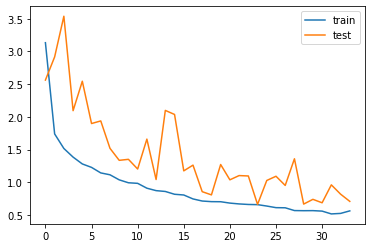

In [30]:
batch_size=32
epochs=75
with tf.device('/gpu:0'):
    history_data_aug = model_augmented.fit_generator(train_datagen.flow(X_train,
                                        y_train,
                                        batch_size=batch_size),
                                        steps_per_epoch=X_train.shape[0]/batch_size,
                                        epochs=epochs,
                                        validation_data=(X_test, y_test),
                                        shuffle=True,
                                        verbose=1,
                                        callbacks=[early_stopping],
                                        )
# plot training history
plt.plot(history_data_aug.history['loss'], label='train')
plt.plot(history_data_aug.history['val_loss'], label='test')
plt.legend()
plt.show()

In [31]:
# Score trained model.
scores = model_augmented.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

30/30 [==============================] - 1s 47ms/step - loss: 0.7101 - accuracy: 0.7737
Test loss: 0.7100759148597717
Test accuracy: 0.7736842036247253


<AxesSubplot:>

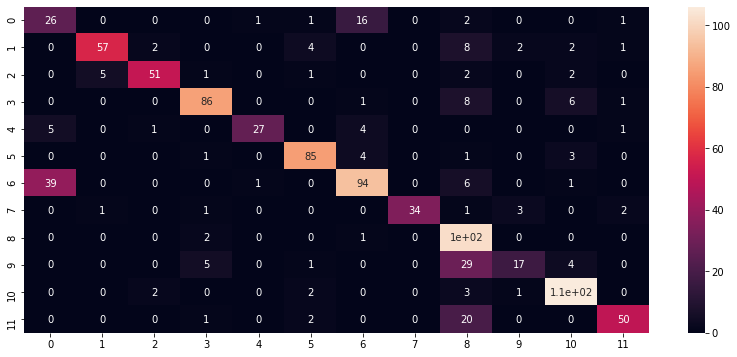

In [32]:
y_pred = model_augmented.predict(X_test)
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
plt.figure(figsize=(14,6))
sns.heatmap(cm,annot=True)

In [33]:
### Augumented model improved the correct prediction of class 0 and class 1 while class 6 has more false predictions 

print(f'Augumented model improved the correct prediction of Label {distinct_labels[0]} and {distinct_labels[1]} while Label {distinct_labels[6]} has more false predictions')

Augumented model improved the correct prediction of Label Small-flowered Cranesbill and Fat Hen while Label Cleavers has more false predictions


### Data augmentation has improved the performance from 73% to 77%

### Summary:

 - Augmented model with more number of epochs(75) has produced better accuracy for our model. 